In [48]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv('main_data.csv')
df = df.dropna(axis=0, how='all')

In [50]:
df.head()

,perfmode,transtotaltime(s),peakresmem(MBytes),numcpu,totalused(%),nodes,bsim4,coreType,errpreset,gmin(S),maxstep(s),abstolV(V),abstolI(A),reltol,method
0,Spectre,5737.82,226.0,32,441.8,103,202,Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz,conservative,1.000000e-12,1.000000e-08,0.000001,1.000000e-12,0.0001,gear2only
1,APS,1808.03,244.0,30,384.5,103,202,Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz,conservative,1.000000e-12,1.000000e-08,0.000001,1.000000e-12,0.0001,gear2only
2,APS++,1067.23,142.0,26,363.4,103,202,Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz,conservative_sigglobal,1.000000e-12,1.000000e-08,0.000001,1.000000e-12,0.0001,gear2only
3,APS++,4330.91,245.0,30,641.0,103,202,Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz,conservative_sigglobal,1.000000e-12,1.000000e-08,0.000001,1.000000e-12,0.0001,gear2only
4,Spectre,1434.95,139.0,25,369.9,103,202,Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz,liberal,1.000000e-12,2.000000e-08,0.000001,1.000000e-12,0.0100,trapgear2


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

In [52]:
def predict_on_unnormalized_input(model, input_data):
    # Convert input data to a DataFrame
    input_df = pd.DataFrame(input_data, index=[0])
    


In [53]:
def preprocess_data(model, scaler, polynomial_features, stages, acc_setting, perf_mode):
    # make a df using the inputs
    input_df = pd.DataFrame({'perfmode': [perf_mode], 'nodes': [stages], 'errpreset': [acc_setting] })
    input_df['errpreset'] = input_df['errpreset'].map({'conservative': 0,
                                         'conservative_sigglobal': 0,
                                         'moderate': 0.5,
                                         'liberal': 1})

    input_df['perfmode'] = input_df['perfmode'].map({'Spectre': 0,
                                        'APS': 0.5,
                                        'APS++': 1})
    
    # Normalize the input data using the same scaler used during training
    input_scaled = scaler.transform(input_df)
    input_polynomial = polynomial_features.transform(input_scaled)
    input_log = np.log(input_df + 1)  # Adding 1 to avoid taking the log of zero
    # Combine the new features with the original features
    input_new = np.hstack((input_polynomial, input_log))
    input_new = np.nan_to_num(input_new)
    
    # Make predictions using the trained model
    prediction = model.predict(input_new)
    
    return prediction
# preprocess_data(model, 5019, 'liberal', 'Spectre')


In [54]:
def create_dataset(df, irrelevant_cols, one_hot_cols, target='time'):
    
    # make a deep copy of the dataframe
    X = df.copy()
    
    # map errpreset and perfmode to numerical values
    X['errpreset'] = X['errpreset'].map({'conservative': 0,
                                         'conservative_sigglobal': 0,
                                         'moderate': 0.5,
                                         'liberal': 1})

    X['perfmode'] = X['perfmode'].map({'Spectre': 0,
                                        'APS': 0.5,
                                        'APS++': 1})  
    # drop the irrelevant columns
    X = X.drop(irrelevant_cols, axis=1)
    
    # one hot encode the one hot columns
    one_hot_cols = [col for col in one_hot_cols if col not in irrelevant_cols]
    X = pd.get_dummies(X, columns=one_hot_cols, dtype=float)

    # extract and drop label column from df
    time = X['transtotaltime(s)'] # minutes
    mem = X['peakresmem(MBytes)'] # GB
    cpu = X['totalused(%)'] # CPUs
    
    if target == 'time':
        y = time # workload
    elif target == 'mem':
        y = mem # memory
    elif target == 'cpu':
        y = cpu
    elif target == 'time_cpu':
        y = time * cpu
    X = X.drop(['transtotaltime(s)', 'peakresmem(MBytes)', 'totalused(%)'], axis=1)

    # drop columns with numpy NaN values
    X = X.dropna(axis=1)
    cols = X.columns

    # normalize all the columns using keras
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=cols)
    
    # Create polynomial features
    polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
    X_polynomial = polynomial_features.fit_transform(X)

    # Create logarithmic features
    X_log = np.log(X + 1)  # Adding 1 to avoid taking the log of zero

    # Combine the new features with the original features
    X_new = np.hstack((X_polynomial, X_log))
    features = polynomial_features.get_feature_names_out().tolist() + [f'log_{col}' for col in cols]
    
    # replace numpy nans with 0
    X_new = np.nan_to_num(X_new)
    
    # add the new features to the dataframe
    X_new = pd.DataFrame(X_new, columns=features)

    return X_new, y, scaler, polynomial_features


In [55]:
def lin_reg(X, y, show=True, rand=42):
    
    X = X.copy()
    y = y.copy()

    # Instantiate a linear regression model
    model = LinearRegression()
    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand)
    if show:
        print('\nTRAIN - TEST SPLIT')
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_test shape: {y_test.shape}")

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # test error
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    test_accuracy = model.score(X_test, y_test)
    if show:
        print('\nTEST SCORE')
        print(f'Test Lin Reg Accuracy: {test_accuracy}')
        print("Test Mean Squared Error:", mse)
        print("Test R-squared:", r2)
    
    # train error
    # mse = mean_squared_error(y_train, y_pred_train)
    # r2 = r2_score(y_train, y_pred_train)
    # train_accuracy = model.score(X_test, y_pred_test)
    # print('\n\n TRAIN SCORE')
    # print(f'Train Lin Reg Accuracy: {train_accuracy}')
    # print("Train Mean Squared Error:", mse)
    # print("Train R-squared:", r2)
    return model, test_accuracy


In [56]:
# create a simple neural network to predict the totalused(%)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def neural_net(X, y, lr=0.001):
    
    X = X.copy()
    y = y.copy()

    model = Sequential()
    model.add(Dense(5, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

    model.fit(X, y, epochs=100, verbose=0)

    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    # print(f'Mean Squared Error: {mse}')

    accuracy = 1 - mse / (y.std() ** 2)
    print(f'Neural Net Accuracy: {accuracy}')
    return

In [57]:
print(len(df[df['coreType'].str.contains('2.4')]))
print(len(df[df['coreType'].str.contains('AMD')]))

97
89


In [58]:
# cols: 
#     ['transtotaltime(s)',     y
#      'peakresmem(MBytes)',    y
#      'totalused(%)',          y
#     'coreType', one hot
#     'maxstep(s)', ignore
#     'reltol', ignore
#     'numcpu', ignore
#     'nodes', linear
#     'bsim4', ignore
#     'errpreset', linear
#     'gmin(S)', ignore
#     'abstolV(V)', ignore
#     'abstolI(A)', ignore
#     'method'] ignore

    perfmode     nodes  errpreset  perfmode^2  perfmode nodes  \
0  -1.206112 -0.892354  -1.212311    1.454707        1.076279   
1   0.025392 -0.892354  -1.212311    0.000645       -0.022659   
2   1.256896 -0.892354  -1.212311    1.579787       -1.121597   
3  -1.206112  1.120631  -1.212311    1.454707       -1.351607   
4   0.025392  1.120631  -1.212311    0.000645        0.028455   
..       ...       ...        ...         ...             ...   
92  0.025392 -0.892354   0.000000    0.000645       -0.022659   
93  1.256896 -0.892354   0.000000    1.579787       -1.121597   
94 -1.206112 -0.892354  -1.212311    1.454707        1.076279   
95  0.025392 -0.892354  -1.212311    0.000645       -0.022659   
96  1.256896 -0.892354  -1.212311    1.579787       -1.121597   

    perfmode errpreset   nodes^2  nodes errpreset  errpreset^2  perfmode^3  \
0             1.462183  0.796296         1.081811     1.469697   -1.754539   
1            -0.030783  0.796296         1.081811     1.469697 

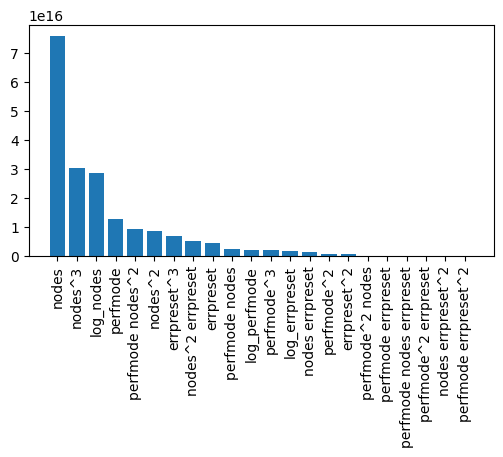

In [64]:

irrelevant_cols = ['reltol', 'method', 'bsim4', 'gmin(S)',  'abstolV(V)', 'abstolI(A)', 'numcpu',  'maxstep(s)',  'coreType']
one_hot_cols = []
linear_cols = ['errpreset', 'nodes', 'perfmode']

def run_1000(core='all', target='time'):
    accs = []
    coefs = {}
    highest_acc = 0
    best_model = None
    for i in range(1000):
        if core == 'all':
            X, y, scaler, polynomial_features = create_dataset(df, irrelevant_cols, one_hot_cols, target)
        else:
            core_mask = df['coreType'].str.contains(core)
            X, y, scaler, polynomial_features = create_dataset(df[core_mask], irrelevant_cols, one_hot_cols, target)
        rand = np.random.randint(0, 10000)
        model, test_acc = lin_reg(X, y, show=False, rand=rand)

        features = X.columns
        coefficients = model.coef_
        
        if test_acc > highest_acc:
            highest_acc = test_acc
            best_model = model
        
        features_and_coefficients = list(zip(features, coefficients))
        features_and_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)
        for feature, coef in features_and_coefficients:
            if feature in coefs:
                coefs[feature].append(abs(coef))
            else:
                coefs[feature] = [abs(coef)]
        accs.append(test_acc)
    
    # Coefficient Histogram
    for feature, coef in coefs.items():
        coefs[feature] = np.mean(coef)
    coefs = {k: v for k, v in sorted(coefs.items(), key=lambda item: item[1], reverse=True)}
    features = list(coefs.keys())
    coefficients = list(coefs.values())

    # label the x axis as "Coefficient" and the y axis as "Magnitude"
    # label the title as "Largest Coefficients in Linear Regression Model"
    # here is the code:
    
    # labels
    # plt.figure(figsize=(8, 3))
    # plt.bar(features, coefficients)
    # plt.xlabel('Coefficient')
    # plt.xticks(rotation=90)
    # plt.ylabel('Mean Magnitude')
    # plt.title('Largest Coefficients in AMD Model')
    
    # save the accs in a csv with name 'accs.csv'
    df_ac = pd.DataFrame({'accuracies': accs})
    df_ac.to_csv('accs.csv', index=False)
        
    # Accuracy histogram
    plt.hist(accs, bins=100)
    plt.xlim(0, 1)
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution of Intel Model over 1000 runs')

    # Percentiles
    # percentiles = np.percentile(accs, [25, 50, 75])
    # plt.boxplot(percentiles)
    # plt.xlabel('Percentile')
    # plt.ylabel('Value')

    plt.show()
    print(f'Median accuracy: {np.median(accs)}')
    return best_model, highest_acc, scaler, polynomial_features

def run_model(core='all', target='time'):
    if core == 'all':
        X, y, _, _ = create_dataset(df, irrelevant_cols, one_hot_cols, target)
    else:
        core_mask = df['coreType'].str.contains(core)
        X, y, _, _ = create_dataset(df[core_mask], irrelevant_cols, one_hot_cols, target)
        print(X)
    # rand = np.random.randint(0, 10000)
    rand = 42
    model, test_acc = lin_reg(X, y, show=False, rand=rand)
    features = X.columns
    coefficients = model.coef_
    features_and_coefficients = list(zip(features, coefficients))
    features_and_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

    # get the features and coefficients from features_and_coefficients
    features_plt = [feature for feature, _ in features_and_coefficients]
    print(len(features_plt))
    coefficients_plt = [abs(coefficient) for _, coefficient in features_and_coefficients]
    plt.figure(figsize=(6, 3))
    plt.bar(features_plt, coefficients_plt)
    plt.xticks(rotation=90)
    plt.show()
    
    return coefficients_plt, features_plt
    
    print(test_acc)

# model, acc, scaler, polynomial_features = run_1000('2.4', 'time')
a,b = run_model('2.4', 'time')

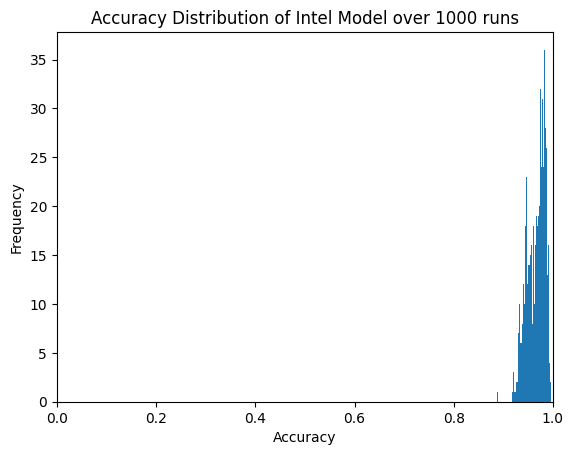

Median accuracy: 0.9696065560235304


(LinearRegression(),
 0.9962606285138432,
 StandardScaler(),
 PolynomialFeatures(degree=3, include_bias=False))

In [66]:
run_1000('AMD', 'time')

    perfmode     nodes  errpreset  perfmode^2  perfmode nodes  \
0  -1.214515  1.011300   1.214515    1.475048       -1.228239   
1   0.013801  1.011300   1.214515    0.000190        0.013957   
2   1.242118  1.011300   1.214515    1.542857        1.256154   
3  -1.214515  1.011300  -0.013801    1.475048       -1.228239   
4   0.013801  1.011300  -0.013801    0.000190        0.013957   
..       ...       ...        ...         ...             ...   
84  0.013801 -0.988826  -0.013801    0.000190       -0.013647   
85  1.242118 -0.988826  -0.013801    1.542857       -1.228239   
86 -1.214515 -0.988826  -1.242118    1.475048        1.200945   
87  0.013801 -0.988826  -1.242118    0.000190       -0.013647   
88  1.242118 -0.988826  -1.242118    1.542857       -1.228239   

    perfmode errpreset   nodes^2  nodes errpreset  errpreset^2  perfmode^3  \
0            -1.475048  1.022727         1.228239     1.475048   -1.791468   
1             0.016762  1.022727         1.228239     1.475048 

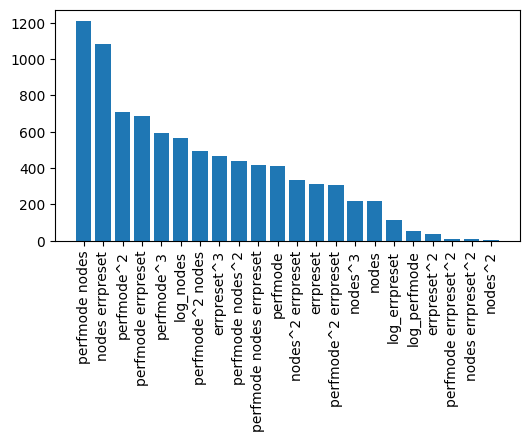

,feature,coefficient
0,perfmode nodes,1212.788953
1,nodes errpreset,1084.260823
2,perfmode^2,707.095256
3,perfmode errpreset,687.588313
4,perfmode^3,594.503719


In [60]:
# create a pd table with the features and coefficients (a and b)
# then export to intel_coefficients.csv
coef, feat = run_model('AMD', 'time')

df_2 = pd.DataFrame({'feature': feat, 'coefficient': coef})
df_2.to_csv('amd_coefficients.csv', index=False)
df_2.head()

In [61]:
preprocess_data(model, scaler, polynomial_features, 103, 'liberal', 'APS++')

NameError: name 'model' is not defined

In [ ]:
model.predict()

TypeError: LinearModel.predict() missing 1 required positional argument: 'X'

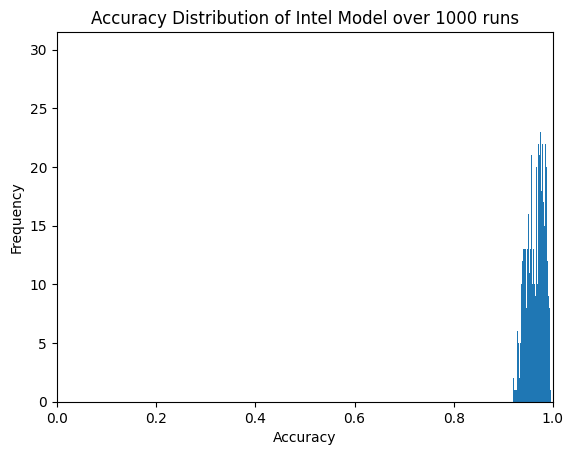

Median accuracy: 0.9693302925559912


(LinearRegression(),
 0.996092411957528,
 StandardScaler(),
 PolynomialFeatures(degree=3, include_bias=False))

In [62]:
run_1000('AMD', 'time')

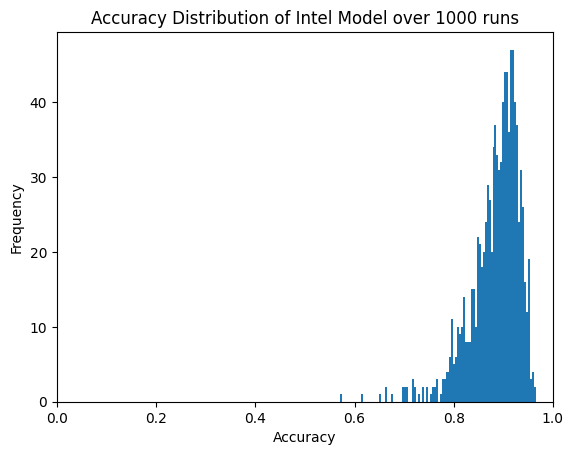

Median accuracy: 0.894652593796372


(LinearRegression(),
 0.965102698324961,
 StandardScaler(),
 PolynomialFeatures(degree=3, include_bias=False))

In [ ]:
run_1000('all', 'time')

    perfmode     nodes  errpreset  perfmode^2  perfmode nodes  \
0  -1.206112 -0.892354  -1.212311    1.454707        1.076279   
1   0.025392 -0.892354  -1.212311    0.000645       -0.022659   
2   1.256896 -0.892354  -1.212311    1.579787       -1.121597   
3  -1.206112  1.120631  -1.212311    1.454707       -1.351607   
4   0.025392  1.120631  -1.212311    0.000645        0.028455   
..       ...       ...        ...         ...             ...   
92  0.025392 -0.892354   0.000000    0.000645       -0.022659   
93  1.256896 -0.892354   0.000000    1.579787       -1.121597   
94 -1.206112 -0.892354  -1.212311    1.454707        1.076279   
95  0.025392 -0.892354  -1.212311    0.000645       -0.022659   
96  1.256896 -0.892354  -1.212311    1.579787       -1.121597   

    perfmode errpreset   nodes^2  nodes errpreset  errpreset^2  perfmode^3  \
0             1.462183  0.796296         1.081811     1.469697   -1.754539   
1            -0.030783  0.796296         1.081811     1.469697 

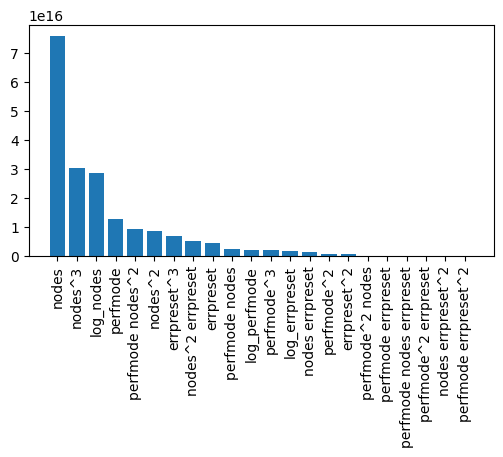

0.9462165877530554


In [ ]:
run_model('2.4', 'time')

    perfmode     nodes  errpreset  perfmode^2  perfmode nodes  \
0  -1.214515  1.011300   1.214515    1.475048       -1.228239   
1   0.013801  1.011300   1.214515    0.000190        0.013957   
2   1.242118  1.011300   1.214515    1.542857        1.256154   
3  -1.214515  1.011300  -0.013801    1.475048       -1.228239   
4   0.013801  1.011300  -0.013801    0.000190        0.013957   
..       ...       ...        ...         ...             ...   
84  0.013801 -0.988826  -0.013801    0.000190       -0.013647   
85  1.242118 -0.988826  -0.013801    1.542857       -1.228239   
86 -1.214515 -0.988826  -1.242118    1.475048        1.200945   
87  0.013801 -0.988826  -1.242118    0.000190       -0.013647   
88  1.242118 -0.988826  -1.242118    1.542857       -1.228239   

    perfmode errpreset   nodes^2  nodes errpreset  errpreset^2  perfmode^3  \
0            -1.475048  1.022727         1.228239     1.475048   -1.791468   
1             0.016762  1.022727         1.228239     1.475048 

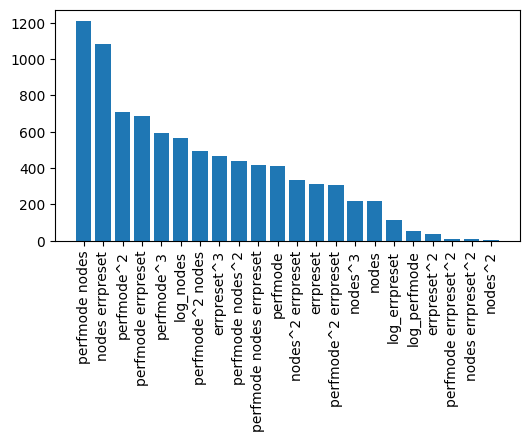

0.962493073740883


In [ ]:
run_model('AMD')


TRAIN - TEST SPLIT
X_train shape: (150, 22)
X_test shape: (65, 22)
y_train shape: (150,)
y_test shape: (65,)

TEST SCORE
Test Lin Reg Accuracy: 0.8964694203079797
Test Mean Squared Error: 0.08400635799945128
Test R-squared: 0.8964694203079797

Features and coefficients:
errpreset: -16164825847141.154
errpreset^3: 11024226433610.635
log_errpreset: 1846949958128.8833
nodes: -1657007934770.2478
nodes^2 errpreset: -903773930616.0168
log_nodes: 702850184754.9739
nodes^3: 560499179259.802
nodes^2: 354447229648.6146
nodes errpreset: 351138989926.5311
perfmode: 247512290437.6752
perfmode nodes^2: -161902915858.9329
log_perfmode: 148081969989.88058
errpreset^2: -128779227081.54399
perfmode^3: -88397574780.71495
perfmode nodes: 62903370427.92072
perfmode^2: -44922414063.70215
perfmode^2 nodes: 0.20989574353806983
perfmode errpreset: 0.19186253224352479
perfmode nodes errpreset: 0.1318975474609744
perfmode^2 errpreset: -0.05450979846242283
perfmode errpreset^2: -0.038489184911679644
nodes errpre

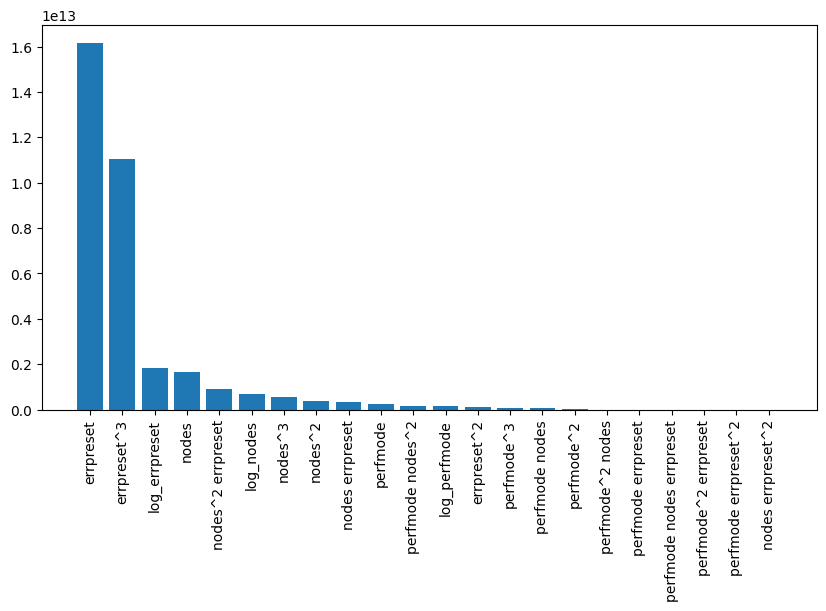

In [ ]:
run_model('both')